In [100]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
# Try out

In [101]:

import numpy as np   #Package for scientific computing and dealing with arrays
import pandas as pd  #Package providing fast, flexible and expressive data structures
import re            #re stands for RegularExpression providing full support for Perl-like Regular Expressions in Python
from bs4 import BeautifulSoup   #Package for pulling data out of HTML and XML files
from keras.preprocessing.sequence import pad_sequences  #For Padding the seqences to same length
from nltk.corpus import stopwords   #For removing filler words
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model  #Helps in grouping the layers into an object with training and inference features
from tensorflow.keras.callbacks import EarlyStopping  #Allows training the model on large no. of training epochs & stop once the performance stops improving on validation dataset
from os import listdir
import string

In [102]:

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
	stories = list()
	for name in listdir(directory):
		filename = directory + '/' + name
		# load document
		doc = load_doc(filename)
		# split into story and highlights
		story, highlights = split_story(doc)
		# store
		stories.append({'story':story, 'highlights':highlights})
	return stories

# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare a translation table to remove punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# strip source cnn office if it exists
		index = line.find('(CNN) -- ')
		if index > -1:
			line = line[index+len('(CNN)'):]
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [w.translate(table) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
	# remove empty strings
	cleaned = [c for c in cleaned if len(c) > 0]
	return cleaned

# load stories
directory = 'cnn/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

# clean stories
for example in stories:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

Loaded Stories 1200


In [103]:
# save to file
from pickle import dump
dump(stories, open('cnn_dataset.pkl', 'wb'))

In [104]:
from pickle import load

# load from file
stories = load(open('cnn_dataset.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 1200


In [105]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import RepeatVector


In [106]:
len(stories)

1200

In [107]:
(stories[0]['story'])

['its one of the smallest countries in africa and one of the poorest in the world but burundi is showing the way in the development of tennis on the continent',
 'ravaged by civil war since gaining independence in the its relative recent political stability has helped it embrace a sport that is battling to maintain its foothold in the planets secondlargest land space',
 'africa has not produced a grand slam singles finalist since kevin curren at the wimbledon championships while wayne ferreira reached the semis of the australian open for the second time in and former world no amanda coetzer was similarly successful in',
 'kevin anderson is currently the continents topranked player at no and yet another south african chanelle scheepers is its top woman at',
 'but the future may lie in a country which is rebuilding itself after conflicts which saw more than half a million people killed and mass migrations of its fleeing population',
 'burundi will soon open africas third highperformance 

In [108]:
#Preprocessing

#This the dictionary used for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [109]:
#Text Cleaning
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()  #converts all uppercase characters in the string into lowercase characters and returns it
    newString = BeautifulSoup(newString, "lxml").text #parses the string into an lxml.html 
    newString = re.sub(r'\([^)]*\)', '', newString) #used to replace a string that matches a regular expression instead of perfect match
    newString = re.sub('"','', newString)           
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #for expanding contractions using the contraction_mapping dictionary    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0): 
      tokens = [w for w in newString.split() if not w in stop_words]  #converting the strings into tokens
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()



In [110]:
ss  = edict()
ss["idan"] = 1
ss["idan"]+1
ss

{'idan': 1}

In [111]:
from easydict import EasyDict as edict

In [112]:
#Calling the function
x_vocab = edict()
y_vocab = edict()

article_word_count = []
abstract_word_count = []

cleaned_text = []
highlights = []

max_ar_length = 0
max_high_lengh = 0

for file in stories:
    t = file['story']
    story =""
    highligh= ""
    h = file['highlights']
    for line in t:
        story= story+line
        for word in line: 
            if word not in x_vocab.keys():
                x_vocab[word] =1
            else: 
                x_vocab[word]+=1

    if len(story.split())> max_ar_length: max_ar_length =len(story.split())
    article_word_count.append(len(story.split()))
    cleaned_text.append(text_cleaner(story,0))
    for line in h:
        highligh= highligh+line
        if word not in y_vocab.keys():
            y_vocab[word] =1
        else: 
            y_vocab[word]+=1

    if len(highligh.split())> max_high_lengh: max_high_lengh =len(highligh.split())
    abstract_word_count.append(len(highligh.split()))
    highlights.append(highligh)

In [113]:
# print summer: 
print(f" Max length sequence story: {max_ar_length}")
print(f" Max length sequence highlight: {max_high_lengh}")



Max length sequence story: 1687
 Max length sequence highlight: 72


In [114]:
type(len(set(cleaned_text[1].split())))

int

In [115]:
test_text = cleaned_text[:100]
val_text = cleaned_text[100:200]
cleaned_text = cleaned_text[200:]
test_highlights = highlights[:100]
val_highlights = highlights[100:200]
highlights = highlights[200:]

In [116]:
len(cleaned_text)

1000

In [117]:
# TODO: some words are not properly split; maybe beginning and ending of sentences?
cleaned_text[0]

'former los alamos national laboratory nuclear scientist wife indicted charges trying provide nuclear secrets venezuela us officials stressed venezuelan government knew nothing plansthe officials said information undercover operation hugo chavezs government plans try build nuclear weaponpedro mascheroni roxby mascheroni us citizens worked contractors los alamos new mexico officials said fridayin mascheroni left laboratory years earlier series conversations undercover fbi agent posing official caracas government according indictmentmascheroni allegedly said could help venezuela develop nuclear bomb within years program venezuela would use secret underground nuclear reactor produce enrich plutonium open aboveground reactor produce nuclear energy justice department saidaccording us justice department statement mascheroni allegedly asked obtaining venezuelan citizenship described expected paid classified nuclear work venezuela mascheroni said fee producing certain information indictment al

In [118]:
new_highlights = []
for highlight in highlights:
    highlight = "sos " + highlight + " eos"
    new_highlights.append(highlight)
highlights = new_highlights
new_val_highlights = []
for highlight in val_highlights:
    highlight = "sos " + highlight + " eos"
    new_val_highlights.append(highlight)
val_highlights = new_val_highlights
print(highlights[0])
print(val_highlights[0])
print(test_highlights[0])

sos new indictment alleges physicist wanted for servicesthe scientist and his wife are accused of trying to provide nuclear secrets to venezuelavenezuelas government knew nothing about the plans officials saythe us citizens worked as contractors at the new mexico laboratory eos
sos george w bush calls his new book on his father a love storybush says his father george hw bush is an extraordinary person eos
african tennis is struggling to produce toplevel professional playersaspiring stars face big obstacles if they are to establish themselves on tourone of the best ways is to win a college scholarship in the united statesotherwise african players are not exposed to toplevel competition while they are young


In [119]:
X_tokenizer = Tokenizer(num_words = 3000)
X_tokenizer.fit_on_texts(cleaned_text)


In [120]:
X_tokenizer.word_counts

vilian', 38),
             ('support', 248),
             ('statesit', 2),
             ('passed', 69),
             ('unanimouslyin', 1),
             ('released', 185),
             ('state', 623),
             ('secretary', 133),
             ('hiliary', 1),
             ('clinton', 68),
             ('commended', 3),
             ('swift', 14),
             ('passage', 23),
             ('resolutionabyei', 1),
             ('source', 86),
             ('regional', 38),
             ('tension', 20),
             ('many', 566),
             ('urge', 13),
             ('parties', 64),
             ('reach', 93),
             ('immediate', 27),
             ('ceasefire', 23),
             ('aid', 91),
             ('workers', 81),
             ('unfettered', 2),
             ('access', 106),
             ('required', 56),
             ('deliver', 25),
             ('humanitarian', 55),
             ('assistance', 46),
             ('innocent', 29),
             ('civilians', 44),
     

In [121]:
# TODO: why 90? this will probably fuck up the embedding layer because we only have 51 words in the abstract and the embedding thinks our vocabulary has size 90
Y_tokenizer = Tokenizer(num_words = 3000)
Y_tokenizer.fit_on_texts(highlights)
Y_voc = Y_tokenizer.num_words

In [122]:
Y_tokenizer.word_counts

            ('both', 16),
             ('lions', 2),
             ('tom', 2),
             ('lewand', 1),
             ('we', 31),
             ('fondly', 1),
             ('remember', 5),
             ('alex', 6),
             ('one', 77),
             ('our', 18),
             ('ownkarras', 1),
             ('sat', 3),
             ('broadcast', 2),
             ('booth', 2),
             ('howard', 2),
             ('cosell', 1),
             ('frank', 2),
             ('giffordhe', 1),
             ('appeared', 3),
             ('movies', 1),
             ('including', 18),
             ('blazing', 1),
             ('saddles', 1),
             ('victor', 3),
             ('victoriain', 1),
             ('april', 7),
             ('karras', 1),
             ('joined', 3),
             ('other', 49),
             ('players', 20),
             ('suing', 2),
             ('nfl', 8),
             ('votes', 4),
             ('measure', 2),
             ('fund', 2),
             ('arm', 5

In [123]:
def word_to_idx(data: list) -> dict:
    """
    Function that maps the data and return a dictionary of words corresponding to their index
    it gets a list
    return:
        dict 1 idx to word
        dict 2 word to idx
    """
    total_letters = [letters for sublist in data for subsublist in sublist for letters in subsublist]
    unique_letters =set(total_letters)
    total_words = [word.replace(',','') for sublist in data for subsublist in sublist for word in subsublist.split()]
    unique_words =list(set(total_words))

    w_2_i = {unique_words[i]:i for i in range(len(unique_words))}
    i_2_w= {i: unique_words[i] for i in range(len(unique_words))}
    print(w_2_i)
    input()
    return (w_2_i, i_2_w)

In [124]:
X_train= X_tokenizer.texts_to_sequences(cleaned_text) 
y_train  = Y_tokenizer.texts_to_sequences(highlights)
X_train = pad_sequences(X_train,  maxlen = max_ar_length, padding = 'post')
y_train =  pad_sequences(y_train,  maxlen = max_high_lengh, padding = 'post')
X_val = X_tokenizer.texts_to_sequences(val_text)
y_val = Y_tokenizer.texts_to_sequences(val_highlights)
X_val = pad_sequences(X_val,  maxlen = max_ar_length, padding = 'post')
y_val = pad_sequences(y_val,  maxlen = max_high_lengh, padding = 'post')
X_test = X_tokenizer.texts_to_sequences(test_text)
X_test = pad_sequences(X_test,  maxlen = max_ar_length, padding = 'post')

In [125]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1000
100
100


In [126]:
print(len(y_train))
print(len(y_val))

1000
100


In [127]:
X_tokenizer.num_words

3000

In [128]:
Y_tokenizer.num_words

3000

In [129]:
X_train[0]

array([ 83, 844,  48, ...,   0,   0,   0], dtype=int32)

In [130]:
y_train[0]

array([   3,   17, 2241,  978,   10, 2242,    8,   24,  202,   15,  255,
          6,  228,    2, 1608,  158,    2,   66, 1609,  567,   38,    1,
        229,   95,  979,   35, 1235,  670,   25,   19,    1,   17, 1236,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [131]:
X_voc = X_tokenizer.num_words

In [132]:
y = np.array(y_train)
x = np.array(X_train)
x_val = np.array(X_val)
y_val = np.array(y_val)

In [133]:
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

(1000, 1687)
(1000, 72)
(100, 1687)
(100, 72)


In [134]:
x

array([[  83,  844,   48, ...,    0,    0,    0],
       [  32,  254,  375, ...,    0,    0,    0],
       [2509,  125, 1032, ...,    0,    0,    0],
       ...,
       [ 544,   99,  381, ...,    0,    0,    0],
       [1557,  483,  553, ...,    0,    0,    0],
       [2792,   31,  738, ...,    0,    0,    0]], dtype=int32)

In [135]:
y

array([[   3,   17, 2241, ...,    0,    0,    0],
       [   3, 2243, 1610, ...,    0,    0,    0],
       [   3,  673, 2244, ...,    0,    0,    0],
       ...,
       [   3,    1,    6, ...,    0,    0,    0],
       [   3,   17,    8, ...,    0,    0,    0],
       [   3, 1535,  333, ...,    0,    0,    0]], dtype=int32)

In [136]:

from keras import backend as K 
K.clear_session()  #Resets all state generated by Keras

latent_dim = 100
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(x.shape[1],))

# TODO: understand how embedding works here; is this our own trained embedding? maybe we should just use word2vec
#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True, mask_zero=True)(encoder_inputs)

#encoder lstm
# TODO: why are we not using an activation function? default is none, only for recurrent activation the default is sigmoid
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=((y.shape[1] - 1),))

#Embedding layer
dec_emb_layer = Embedding(Y_voc, embedding_dim,trainable=True, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
decoder_outputs ,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb ,initial_state=[state_h, state_c])

# #Attention layer; removed for now
# attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# #Concating Attention input and Decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
# TODO: figure out what TimeDistributed does
decoder_dense =  TimeDistributed(Dense(units = Y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

#Defining the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='training_model_plot.png', show_shapes=True, show_layer_names=True)

# TODO: understand this
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

#Adding Callback
# TODO: how exactly does this work? is there an internal mapping of the string "val_loss" to running a test on the specified validation_data?
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

# Commented out IPython magic to ensure Python compatibility.
#Training the Model
# %tensorflow_version 1.x
# indexing is clear, removing the eos token for the decoder inpu
# ts and removing the sos token for the decoder outputs
# TODO: think about how exactly this is working with calculating the loss etc., maybe that's the problem
# TODO: fit only on one example and check if model actually works
# this creates the third dimension we need to compare to the generated output of the decoder; basically creates "one-hot encoding" to generate the probability distribution
history = model.fit(
    x = [x,y[:,:-1]], 
    y = y.reshape(y.shape[0], y.shape[1], 1)[:, 1:, :],
    epochs=500,
    batch_size = 100,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
)




[==============================] - 66s 7s/step - loss: 1.2635 - accuracy: 0.4230 - val_loss: 3.0635 - val_accuracy: 0.1119
Epoch 362/500
10/10 [==============================] - 66s 7s/step - loss: 1.2673 - accuracy: 0.4215 - val_loss: 3.0623 - val_accuracy: 0.1078
Epoch 363/500
10/10 [==============================] - 65s 7s/step - loss: 1.2597 - accuracy: 0.4235 - val_loss: 3.0666 - val_accuracy: 0.1085
Epoch 364/500
10/10 [==============================] - 66s 7s/step - loss: 1.2617 - accuracy: 0.4232 - val_loss: 3.0633 - val_accuracy: 0.1075
Epoch 365/500
10/10 [==============================] - 65s 7s/step - loss: 1.2543 - accuracy: 0.4262 - val_loss: 3.0686 - val_accuracy: 0.1092
Epoch 366/500
10/10 [==============================] - 66s 7s/step - loss: 1.2513 - accuracy: 0.4267 - val_loss: 3.0691 - val_accuracy: 0.1092
Epoch 367/500
10/10 [==============================] - 65s 6s/step - loss: 1.2516 - accuracy: 0.4285 - val_loss: 3.0775 - val_accuracy: 0.1062
Epoch 368/500
10/10

In [148]:
#Building Dictionary for Source Vocabulary
# TODO: what is happening here? we are just saving the vocabularies of the tokenizers (index -> word or word -> index maps)
target_index_word=Y_tokenizer.index_word 
source_index_word=X_tokenizer.index_word 
target_word_index=Y_tokenizer.word_index

#Testing phase
#Encoding the input sequence to get the feature vector
# TODO: is this what links this model to the trained model? that we use the same encoder_inputs Input object?
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#These tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
# TODO: remove this, probably only used for attention
# decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Getting the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

#Setting the initial states to the states from the previous time step for better prediction
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# TODO: remove this
# #Attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

#Final Decoder model
# TODO: how is this all linked to what we trained before? where does the parameter sharing happen?
# TODO: why are we appending the lists instead of just writing it in one list
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#Function defining the implementation of inference process
def decode_sequence(input_seq):
    #Encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    #Populating the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        #Sampling a token
        # TODO: understand the indexing: why -1 instead of 0 as well? shouldn't the output tokens be of shape (1, 1, num_words)?
        # TODO: I think the neurons in the dense layer start at 0 but our dictionary starts at 1, despite a one-on-one mapping from
        # dictionary index numbers to neurons if I understand correctly; doesn't make sense to make, programm will crash if arg_max returns zero
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = target_index_word[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #Exit condition: either hit max length or find stop word
        # TODO: it used to be >= (max_abstract_len - 1); why? doesn't make sense to me
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) == max_high_lengh):
            stop_condition = True

        #Updating the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Updating internal states
        e_h, e_c = h, c

    return decoded_sentence

#Functions to convert an integer sequence to a word sequence for summary as well as reviews 
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sos']) and i!=target_word_index['eos']):
            newString=newString+target_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+source_index_word[i]+' '
    return newString

#Summaries generated by the model
X_test = np.array(X_test)
results_file = open("results.txt", "w")
for i in range(len(test_text)):
    original_article = f"Original article:\n {test_text[i]}\n\n"
    original_summary = f"Original summary:\n {test_highlights[i]}\n\n"
    predicted_summary = f"Predicted summary:\n {decode_sequence(X_test[i].reshape(1,-1))}\n\n"
    results_file.writelines([original_article, original_summary, predicted_summary])
results_file.close()
    
    

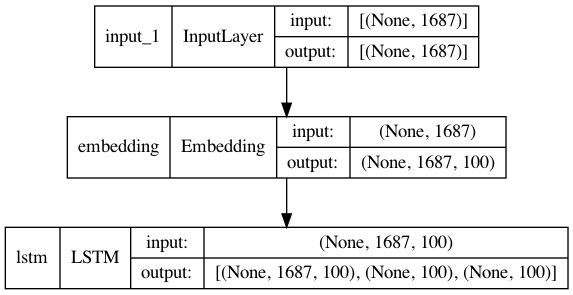

In [150]:
plot_model(encoder_model, to_file='prediction_model_encoder_plot.png', show_shapes=True, show_layer_names=True)

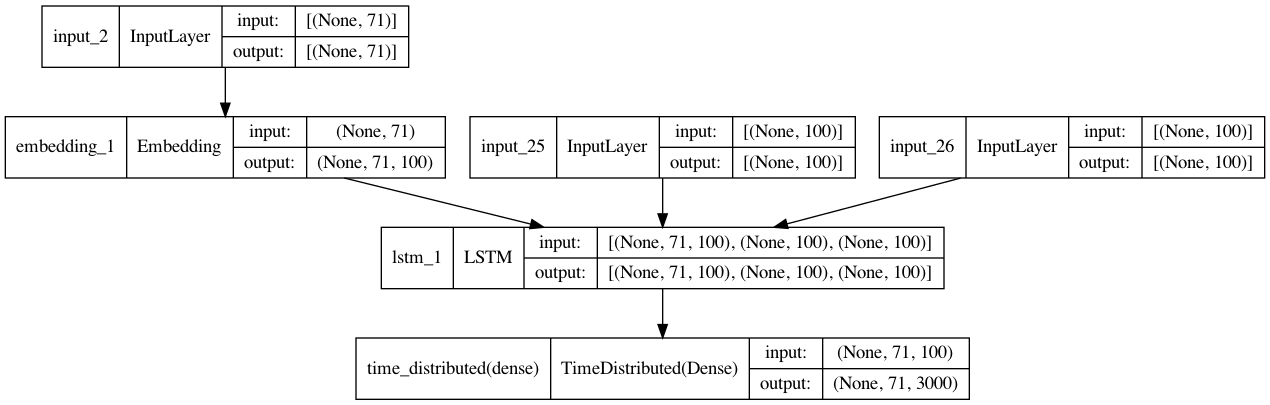

In [151]:
plot_model(decoder_model, to_file='prediction_model_decoder_plot.png', show_shapes=True, show_layer_names=True)